In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import gensim
import pickle as cPickle
from sklearn.model_selection import train_test_split,cross_val_score,validation_curve
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn import metrics
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt





from google.colab import drive
drive.mount('/content/drive',force_remount=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/My Drive/thesis/feature_engineering/features_b.tsv', sep='\t', engine="python")

In [3]:
df.head()

,id,q1_id,q2_id,q1,c1,q2,c2,annotation,len_q1,len_q2,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...","""I have a 120/240 dryer from Canada, and want ...","""The dryer electric driagram identifies a RED...",1,113,75,...,14.403063,1.0,186.662762,1.046549,0.477926,0.623423,0.111695,0.134371,-0.291058,0.192113
1,1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Powering 220V-to-neutral appliance from 120V s...,"""I have a 5kW appliance that normally accepts ...",1,113,57,...,15.916084,1.0,192.533552,1.108200,0.485541,0.681571,0.111695,-0.257737,-0.291058,0.001935
2,2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"""I have a Champion 120V generator, I want to u...","""I have a new champion generator, 120volt at 2...",Is it possible to wire a 240v outlet so that a...,"""I'm in the US. I will be installing a 240v ou...",1,113,107,...,12.253480,1.0,166.827121,0.903024,0.411576,0.498201,0.111695,0.035383,-0.291058,0.128723
3,3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Is there an advantage to using EMT over Plasti...,"""I am planning a structured wiring project. As...",0,77,86,...,11.958934,1.0,174.609626,0.838662,0.373282,0.488841,-0.014840,-0.203645,0.192689,-0.029994
4,4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,"""I was wondering if I could run 120v wires ins...",Which cable/conduit should I use to run a new ...,"""I'm in the middle of a kitchen remodel and ha...",1,77,72,...,14.625247,1.0,189.084447,1.039617,0.468540,0.628236,-0.014840,-0.138070,0.192689,0.001311


In [4]:
#removing extra double qoutation marks
df['q1']= df['q1'].apply(lambda s:s.replace('"', ""))
df['q2']= df['q2'].apply(lambda s:s.replace('"', ""))
df['c1']= df['c1'].apply(lambda s:s.replace('"', ""))
df['c2']= df['c2'].apply(lambda s:s.replace('"', ""))


In [5]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, q1_id, q2_id, q1, c1, q2, c2, annotation, len_q1, len_q2, diff_len, len_char_q1, len_char_q2, len_word_q1, len_word_q2, common_words, fuzz_qratio, fuzz_WRatio, fuzz_partial_ratio, fuzz_partial_token_set_ratio, fuzz_partial_token_sort_ratio, fuzz_token_set_ratio, fuzz_token_sort_ratio, wmd, norm_wmd, w2v_q1, w2v_q2, cosine_distance, cityblock_distance, jaccard_distance, canberra_distance, euclidean_distance, minkowski_distance, braycurtis_distance, skew_q1vec, skew_q2vec, kur_q1vec, kur_q2vec]
Index: []

[0 rows x 38 columns]


In [6]:
with open(r"/content/drive/My Drive/thesis/feature_engineering/vectorization/q1_w2v_b.pkl", "rb") as input_file:
  Vq1 = cPickle.load(input_file)

with open(r"/content/drive/My Drive/thesis/feature_engineering/vectorization/q2_w2v_b.pkl", "rb") as input_file:
  Vq2 = cPickle.load(input_file)


In [7]:
Vq1.shape

(8299, 300)

In [8]:
#for i in range(len(df)):
##  if df["wmd"][i]=="inf" :
#    df["wmd"][i]=0
#    df["norm_wmd"]==0
df['wmd'] = df['wmd'].astype('str')
df.wmd = df.wmd.replace({"inf": "0"})
df['norm_wmd'] = df['norm_wmd'].astype('str')
df.norm_wmd = df.norm_wmd.replace({"inf": "0"})


In [9]:
df_temp = pd.DataFrame(columns=['q1_vec'])
df_temp['q1_vec'] = list(Vq1)

df3_q1v = pd.DataFrame(df_temp.q1_vec.values.tolist(),index=df.index)
del df_temp
df3_q1v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.046618,-0.008492,0.018056,0.005220,-0.092761,0.002242,0.046530,-0.120234,0.063670,0.092586,...,-0.006303,0.049053,-0.089864,-0.087177,-0.119035,-0.067960,-0.019656,-0.029472,-0.015298,-0.021963
1,0.046618,-0.008492,0.018056,0.005220,-0.092761,0.002242,0.046530,-0.120234,0.063670,0.092586,...,-0.006303,0.049053,-0.089864,-0.087177,-0.119035,-0.067960,-0.019656,-0.029472,-0.015298,-0.021963
2,0.046618,-0.008492,0.018056,0.005220,-0.092761,0.002242,0.046530,-0.120234,0.063670,0.092586,...,-0.006303,0.049053,-0.089864,-0.087177,-0.119035,-0.067960,-0.019656,-0.029472,-0.015298,-0.021963
3,0.003694,-0.029446,-0.026144,-0.050642,-0.107010,-0.085745,0.008690,0.003968,0.059861,0.126335,...,-0.046909,-0.062714,-0.046733,0.013441,-0.098271,-0.040463,-0.010167,-0.000024,-0.035642,-0.033026
4,0.003694,-0.029446,-0.026144,-0.050642,-0.107010,-0.085745,0.008690,0.003968,0.059861,0.126335,...,-0.046909,-0.062714,-0.046733,0.013441,-0.098271,-0.040463,-0.010167,-0.000024,-0.035642,-0.033026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,-0.038923,0.100195,0.025566,-0.026696,-0.017904,0.017237,-0.011922,-0.149753,0.105141,0.085495,...,-0.025997,0.069233,-0.059294,0.035814,-0.057642,-0.002482,-0.037384,0.018782,-0.068681,-0.004309
8295,-0.067869,0.082887,0.013590,-0.077435,-0.044868,0.029928,0.004506,-0.022739,0.042462,0.060633,...,0.074968,0.064305,-0.058950,-0.004436,-0.090636,-0.059450,0.020288,0.008824,-0.052462,-0.043018
8296,-0.116628,0.100569,-0.001976,-0.059537,-0.067389,0.049535,-0.068474,-0.043201,0.108777,0.052879,...,0.070173,-0.038798,-0.037378,0.045270,-0.051247,-0.049987,-0.012599,-0.016453,-0.006700,-0.109407
8297,0.023012,0.066318,0.044636,0.011564,-0.061664,0.052211,0.053512,-0.077694,0.105375,0.032530,...,-0.009135,0.000173,-0.056374,0.060421,-0.012836,-0.096384,0.018907,-0.042053,-0.051007,-0.041716


In [10]:
df_temp = pd.DataFrame(columns=['q2_vec'])
df_temp['q2_vec'] = list(Vq2)

df3_q2v = pd.DataFrame(df_temp.q2_vec.values.tolist(),index=df.index)
del df_temp
df3_q2v

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.026894,0.003354,-0.007398,0.081792,-0.003485,0.033001,0.082721,-0.075570,0.023795,0.023968,...,-0.025382,0.112443,-0.040308,0.055843,0.052112,-0.040736,-0.004636,-0.031727,0.001381,0.015979
1,0.032898,0.095513,-0.014103,-0.063189,0.033367,0.107504,0.028623,-0.046062,0.152237,0.138890,...,-0.079559,0.011053,-0.068298,0.030056,0.013738,-0.043169,0.026511,0.018039,0.033132,0.053387
2,-0.006644,0.007814,-0.028821,0.048016,-0.075456,-0.049114,0.042519,-0.021268,0.039072,0.051221,...,-0.007648,-0.022272,-0.084351,0.052680,-0.074147,-0.062488,-0.047468,-0.031382,-0.062591,-0.048895
3,-0.014693,0.021564,-0.041914,-0.007552,-0.051993,0.056945,0.022957,-0.093651,0.013128,0.114852,...,-0.088709,0.018778,-0.106216,0.019275,-0.126153,0.004734,0.029296,0.022799,-0.078103,0.031711
4,-0.016204,0.030983,0.057819,-0.019555,-0.005051,-0.026920,-0.000480,-0.114170,0.017710,0.137140,...,-0.005319,0.108047,-0.161041,0.102079,-0.039294,-0.099130,-0.016476,-0.013065,-0.022814,-0.012550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,-0.019869,0.045436,-0.017661,-0.010213,-0.064393,0.006910,0.015587,-0.065473,0.123824,0.054958,...,-0.111845,0.078878,-0.034230,-0.014010,-0.010858,-0.007605,-0.041760,-0.006832,-0.012316,-0.046987
8295,-0.095529,0.108274,-0.021779,0.004601,-0.018425,0.019128,0.083397,-0.040590,0.113528,0.129687,...,-0.002019,-0.048012,-0.080310,0.022888,-0.030448,-0.006481,0.040848,0.051767,0.104731,-0.105800
8296,-0.079495,0.000241,-0.015813,0.070107,-0.080896,0.022088,-0.069212,-0.057857,-0.011122,0.044971,...,0.051326,0.028693,0.035843,0.025230,-0.034488,0.037162,-0.042810,-0.039482,0.050319,0.012061
8297,0.007691,0.095450,0.033282,0.025316,-0.048148,0.073659,0.055530,-0.054649,0.121521,0.003966,...,-0.050197,-0.023485,-0.066334,0.016069,-0.031084,-0.088886,0.015245,-0.051264,-0.076552,0.007714


In [11]:
###Merging vectors' df to primary df

In [12]:
df.drop('id', inplace=True, axis=1)
df3_q1v.index.name='id'
df3_q2v.index.name='id'
df = df.merge(df3_q1v, on='id',how='left')
df = df.merge(df3_q2v, on='id',how='left')
display(df)

,q1_id,q2_id,q1,c1,q2,c2,annotation,len_q1,len_q2,diff_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
id,,,,,,,,,,,,,,,,,,,,,
0,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/124266...,"I have a Champion 120V generator, I want to us...","I have a new champion generator, 120volt at 20...","I have a 120/240 dryer from Canada, and want t...",The dryer electric driagram identifies a RED ...,1,113,75,38,...,-0.025382,0.112443,-0.040308,0.055843,0.052112,-0.040736,-0.004636,-0.031727,0.001381,0.015979
1,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/153176...,"I have a Champion 120V generator, I want to us...","I have a new champion generator, 120volt at 20...",Powering 220V-to-neutral appliance from 120V s...,I have a 5kW appliance that normally accepts 3...,1,113,57,56,...,-0.079559,0.011053,-0.068298,0.030056,0.013738,-0.043169,0.026511,0.018039,0.033132,0.053387
2,https://diy.stackexchange.com/questions/204261...,https://diy.stackexchange.com/questions/202610...,"I have a Champion 120V generator, I want to us...","I have a new champion generator, 120volt at 20...",Is it possible to wire a 240v outlet so that a...,I'm in the US. I will be installing a 240v out...,1,113,107,6,...,-0.007648,-0.022272,-0.084351,0.052680,-0.074147,-0.062488,-0.047468,-0.031382,-0.062591,-0.048895
3,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/47210/...,Can I run conduit containing 120V wires inside...,I was wondering if I could run 120v wires insi...,Is there an advantage to using EMT over Plasti...,I am planning a structured wiring project. As ...,0,77,86,-9,...,-0.088709,0.018778,-0.106216,0.019275,-0.126153,0.004734,0.029296,0.022799,-0.078103,0.031711
4,https://diy.stackexchange.com/questions/204189...,https://diy.stackexchange.com/questions/63235/...,Can I run conduit containing 120V wires inside...,I was wondering if I could run 120v wires insi...,Which cable/conduit should I use to run a new ...,I'm in the middle of a kitchen remodel and hav...,1,77,72,5,...,-0.005319,0.108047,-0.161041,0.102079,-0.039294,-0.099130,-0.016476,-0.013065,-0.022814,-0.012550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,https://diy.stackexchange.com/questions/7962/h...,https://diy.stackexchange.com/questions/6298/h...,How can I reduce heat transfer around my windo...,I have three old window units in my house and ...,How do I install a portable air conditioning u...,I have a large sliding window that is 53 inche...,1,70,76,-6,...,-0.111845,0.078878,-0.034230,-0.014010,-0.010858,-0.007605,-0.041760,-0.006832,-0.012316,-0.046987
8295,https://diy.stackexchange.com/questions/7776/a...,https://diy.stackexchange.com/questions/6116/c...,AC Coolant pipe has condensation and leaks ins...,I've got an old AC unit (probably 13+ years ol...,Corrosion on copper pipes due to insulation (w...,My incoming water pipe is copper and it is a b...,1,54,55,-1,...,-0.002019,-0.048012,-0.080310,0.022888,-0.030448,-0.006481,0.040848,0.051767,0.104731,-0.105800
8296,https://diy.stackexchange.com/questions/7684/w...,https://diy.stackexchange.com/questions/1717/a...,What should be cleaned or examined after an ai...,"The other day, we found some water on the floo...",Are clogs in the AC condensate drain common in...,I have a two year old central A/C unit. Every...,1,76,55,21,...,0.051326,0.028693,0.035843,0.025230,-0.034488,0.037162,-0.042810,-0.039482,0.050319,0.012061


In [13]:
# longest string >> for adding padding
pad_1 = df.q2.map(len).max()
pad_2 = df.q1.map(len).max()
print(max(pad_1, pad_2))

150


In [14]:
df.drop(['q1_id', 'q2_id', 'q1', 'c1', 'q2', 'c2','w2v_q1', 'w2v_q2'], inplace=True, axis=1)
df = df.dropna()

In [15]:
cols_toCheck=df.columns[:-600:]
cols_toCheck

Index(['annotation', 'len_q1', 'len_q2', 'diff_len', 'len_char_q1',
       'len_char_q2', 'len_word_q1', 'len_word_q2', 'common_words',
       'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
       'cosine_distance', 'cityblock_distance', 'jaccard_distance',
       'canberra_distance', 'euclidean_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'kur_q2vec'],
      dtype='object')

In [16]:
cols = ['annotation',
  
 '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x',
 '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x',
 '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x',
 '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x',
 '41_x', '42_x', '43_x', '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x',
 '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x',
 '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x',
 '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x', '78_x', '79_x', '80_x',
 '81_x', '82_x', '83_x', '84_x', '85_x', '86_x', '87_x', '88_x', '89_x', '90_x',
 '91_x', '92_x', '93_x', '94_x', '95_x', '96_x', '97_x', '98_x', '99_x', '100_x',
 '101_x', '102_x', '103_x', '104_x', '105_x', '106_x', '107_x', '108_x', '109_x', '110_x',
 '111_x', '112_x', '113_x', '114_x', '115_x', '116_x', '117_x', '118_x', '119_x', '120_x',
 '121_x', '122_x', '123_x', '124_x', '125_x', '126_x', '127_x', '128_x', '129_x', '130_x',
 '131_x', '132_x', '133_x', '134_x', '135_x', '136_x', '137_x', '138_x', '139_x', '140_x',
 '141_x', '142_x', '143_x', '144_x', '145_x', '146_x', '147_x', '148_x', '149_x', '150_x',
 '151_x', '152_x', '153_x', '154_x', '155_x', '156_x', '157_x', '158_x', '159_x', '160_x',
 '161_x', '162_x', '163_x', '164_x', '165_x', '166_x', '167_x', '168_x', '169_x', '170_x',
 '171_x', '172_x', '173_x', '174_x', '175_x', '176_x', '177_x', '178_x', '179_x', '180_x',
 '181_x', '182_x', '183_x', '184_x', '185_x', '186_x', '187_x', '188_x', '189_x', '190_x',
 '191_x', '192_x', '193_x', '194_x', '195_x', '196_x', '197_x', '198_x', '199_x', '200_x',
 '201_x', '202_x', '203_x', '204_x', '205_x', '206_x', '207_x', '208_x', '209_x', '210_x',
 '211_x', '212_x', '213_x', '214_x', '215_x', '216_x', '217_x', '218_x', '219_x', '220_x',
 '221_x', '222_x', '223_x', '224_x', '225_x', '226_x', '227_x', '228_x', '229_x', '230_x',
 '231_x', '232_x', '233_x', '234_x', '235_x', '236_x', '237_x', '238_x', '239_x', '240_x',
 '241_x', '242_x', '243_x', '244_x', '245_x', '246_x', '247_x', '248_x', '249_x', '250_x',
 '251_x', '252_x', '253_x', '254_x', '255_x', '256_x', '257_x', '258_x', '259_x', '260_x',
 '261_x', '262_x', '263_x', '264_x', '265_x', '266_x', '267_x', '268_x', '269_x', '270_x',
 '271_x', '272_x', '273_x', '274_x', '275_x', '276_x', '277_x', '278_x', '279_x', '280_x',
 '281_x', '282_x', '283_x', '284_x', '285_x', '286_x', '287_x', '288_x', '289_x', '290_x',
 '291_x', '292_x', '293_x', '294_x', '295_x', '296_x', '297_x', '298_x', '299_x',
 '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y',
 '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y',
 '21_y', '22_y', '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y',
 '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y',
 '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y', '49_y', '50_y',
 '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', '58_y', '59_y', '60_y',
 '61_y', '62_y', '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y',
 '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y', '80_y',
 '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y', '88_y', '89_y', '90_y',
 '91_y', '92_y', '93_y', '94_y', '95_y', '96_y', '97_y', '98_y', '99_y', '100_y',
 '101_y', '102_y', '103_y', '104_y', '105_y', '106_y', '107_y', '108_y', '109_y', '110_y',
 '111_y', '112_y', '113_y', '114_y', '115_y', '116_y', '117_y', '118_y', '119_y', '120_y',
 '121_y', '122_y', '123_y', '124_y', '125_y', '126_y', '127_y', '128_y', '129_y', '130_y',
 '131_y', '132_y', '133_y', '134_y', '135_y', '136_y', '137_y', '138_y', '139_y', '140_y',
 '141_y', '142_y', '143_y', '144_y', '145_y', '146_y', '147_y', '148_y', '149_y', '150_y',
 '151_y', '152_y', '153_y', '154_y', '155_y', '156_y', '157_y', '158_y', '159_y', '160_y',
 '161_y', '162_y', '163_y', '164_y', '165_y', '166_y', '167_y', '168_y', '169_y', '170_y',
 '171_y', '172_y', '173_y', '174_y', '175_y', '176_y', '177_y', '178_y', '179_y', '180_y',
 '181_y', '182_y', '183_y', '184_y', '185_y', '186_y', '187_y', '188_y', '189_y', '190_y',
 '191_y', '192_y', '193_y', '194_y', '195_y', '196_y', '197_y', '198_y', '199_y', '200_y',
 '201_y', '202_y', '203_y', '204_y', '205_y', '206_y', '207_y', '208_y', '209_y', '210_y',
 '211_y', '212_y', '213_y', '214_y', '215_y', '216_y', '217_y', '218_y', '219_y', '220_y',
 '221_y', '222_y', '223_y', '224_y', '225_y', '226_y', '227_y', '228_y', '229_y', '230_y',
 '231_y', '232_y', '233_y', '234_y', '235_y', '236_y', '237_y', '238_y', '239_y', '240_y',
 '241_y', '242_y', '243_y', '244_y', '245_y', '246_y', '247_y', '248_y', '249_y', '250_y', 
 '251_y', '252_y', '253_y', '254_y', '255_y', '256_y', '257_y', '258_y', '259_y', '260_y',
 '261_y', '262_y', '263_y', '264_y', '265_y', '266_y', '267_y', '268_y', '269_y', '270_y',
 '271_y', '272_y', '273_y', '274_y', '275_y', '276_y', '277_y', '278_y', '279_y', '280_y',
 '281_y', '282_y', '283_y', '284_y', '285_y', '286_y', '287_y', '288_y', '289_y', '290_y',
 '291_y', '292_y', '293_y', '294_y', '295_y', '296_y', '297_y', '298_y', '299_y']

In [17]:
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)


In [18]:
df2 = pd.DataFrame(columns=['annotation'])
df2["annotation"] = df["annotation"]


In [19]:
cols.remove('annotation')
X = df[cols]
y = df2["annotation"]


In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =11)
print(x_train.shape,x_test.shape)

(6639, 600) (1660, 600)


In [21]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
        
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Random Forest

##Hyperparameter tuning

In [22]:
# # Number of trees in random forest
# n_estimators =[100, 600, 900, 1800, 3000]

# # Maximum number of levels in tree
# max_depth = [300,600,900,1200]

# param_grid = {'n_estimators': n_estimators,
#               'max_depth': max_depth }
# print(param_grid)

In [23]:
# rf_Model = RandomForestClassifier()
# rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2)
# rf_Grid.fit(x_train, y_train)

In [24]:
# best_p = rf_Grid.best_params_
# b_p was n_estimators=900, max_depth=300

In [25]:
# print (f'Train Accuracy - : {rf_Grid.score(x_train,y_train):.3f}')
# print (f'Test Accuracy - : {rf_Grid.score(x_test,y_test):.3f}')

##Random Forest with Best Hyperparameter

Accuracy: 0.45481927710843373

Precision-mac: 0.4514827592304432
Precision-w: 0.4520104121583635
Recall-mac: 0.4021810490908768
Recall-w: 0.45481927710843373
F1 Score-mac: 0.38305336316261634
F1 Score-w: 0.4111833529429324


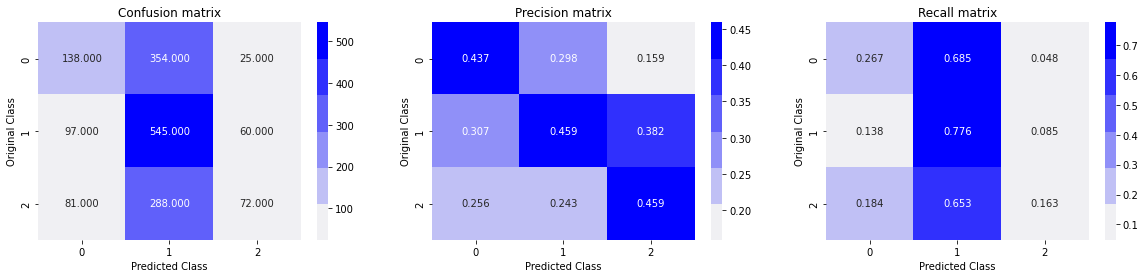

In [26]:
rfc = RandomForestClassifier(n_estimators=900, max_depth=300)
rfc.fit(x_train,y_train)
rfc_predict = rfc.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, rfc_predict))
print("")
print("Precision-mac:",metrics.precision_score(y_test, rfc_predict, average='macro'))
print("Precision-w:",metrics.precision_score(y_test, rfc_predict, average='weighted'))
print("Recall-mac:",metrics.recall_score(y_test, rfc_predict, average='macro'))
print("Recall-w:",metrics.recall_score(y_test, rfc_predict, average='weighted'))
print("F1 Score-mac:",metrics.f1_score(y_test, rfc_predict, average='macro'))
print("F1 Score-w:",metrics.f1_score(y_test, rfc_predict, average='weighted'))
# Model Accuracy, how often is the classifier correct?

plot_confusion_matrix(y_test, rfc_predict)
plt.show()


#Linear SVM

##Hyperparameter tuning

In [27]:
# alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# log_error_array=[]
# for i in alpha:
#     clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
#     clf.fit(x_train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(x_train, y_train)
#     predict_y = sig_clf.predict_proba(x_test)
#     log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
#     print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()

# best_alpha = np.argmin(log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
# clf.fit(x_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(x_train, y_train)

# predict_y = sig_clf.predict_proba(x_train)
# print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(x_test)
# print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)
# print("Total number of data points :", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

In [28]:
best_alpha =  0.0001

##LinearSVM withpipeline


In [29]:
svmc = make_pipeline(StandardScaler(), SVC(gamma='auto',decision_function_shape='ovo'))
svmc.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(decision_function_shape='ovo', gamma='auto'))])

Accuracy: 0.4530120481927711

Precision-mac: 0.43132506262894194
Precision-w: 0.4370132144959147
Recall-mac: 0.4010699983344361
Recall-w: 0.4530120481927711
F1 Score-mac: 0.37971682898260983
F1 Score-w: 0.41028998546277273


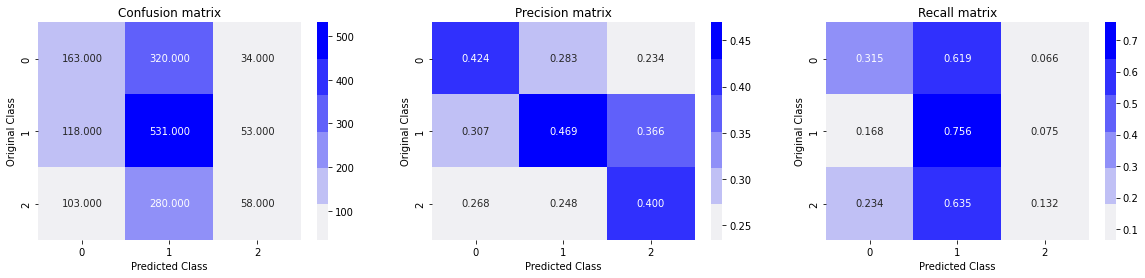

In [30]:
svmc_predict = svmc.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, svmc_predict))
print("")
print("Precision-mac:",metrics.precision_score(y_test, svmc_predict, average='macro'))
print("Precision-w:",metrics.precision_score(y_test, svmc_predict, average='weighted'))
print("Recall-mac:",metrics.recall_score(y_test, svmc_predict, average='macro'))
print("Recall-w:",metrics.recall_score(y_test, svmc_predict, average='weighted'))
print("F1 Score-mac:",metrics.f1_score(y_test, svmc_predict, average='macro'))
print("F1 Score-w:",metrics.f1_score(y_test, svmc_predict, average='weighted'))

plot_confusion_matrix(y_test, svmc_predict)
plt.show()

In [31]:
print(classification_report(y_test.to_numpy(),rfc_predict))

              precision    recall  f1-score   support

           0       0.44      0.27      0.33       517
           1       0.46      0.78      0.58       702
           2       0.46      0.16      0.24       441

    accuracy                           0.45      1660
   macro avg       0.45      0.40      0.38      1660
weighted avg       0.45      0.45      0.41      1660



In [32]:
print(classification_report(y_test.to_numpy(),svmc_predict))

              precision    recall  f1-score   support

           0       0.42      0.32      0.36       517
           1       0.47      0.76      0.58       702
           2       0.40      0.13      0.20       441

    accuracy                           0.45      1660
   macro avg       0.43      0.40      0.38      1660
weighted avg       0.44      0.45      0.41      1660

